# Coverage of gene sets of interest

Plots related to the coverge of PPI data for different subsets of the genome of biomedical interest.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import math

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.patches import Wedge
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
pd.set_option('display.max_columns', 50)
from bioservices import BioMart

import ccsblib
from ccsblib import huri
from ccsblib import ccsbplotlib as cplt

from custom_settings import *
from utils import *

In [2]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 7.0
mpl.rcParams['savefig.dpi'] = 500

In [3]:
omim = pd.read_table('../data/external/genemap2.txt',
                     names=['Chromosome',
                            'Genomic Position Start',
                            'Genomic Position End',
                            'Cyto Location',
                            'Computed Cyto Location',
                            'Mim Number',
                            'Gene Symbols',
                            'Gene Name',
                            'Approved Symbol',
                            'Entrez Gene ID',
                            'Ensembl Gene ID',
                            'Comments',
                            'Phenotypes',
                            'Mouse Gene Symbol/ID'],
                     comment='#')
# the file contains all genes, so filter for those
# with disease annotation
omim = omim.loc[omim['Phenotypes'].notnull(), :]
omim = omim.loc[omim['Ensembl Gene ID'].notnull(), :]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  app.launch_new_instance()


In [4]:
omim.head()

,Chromosome,Genomic Position Start,Genomic Position End,Cyto Location,Computed Cyto Location,Mim Number,Gene Symbols,Gene Name,Approved Symbol,Entrez Gene ID,Ensembl Gene ID,Comments,Phenotypes,Mouse Gene Symbol/ID
21,chr1,1013466,1014539,1p36.33,1p36.33,147571,"ISG15, G1P2, IFI15, IMD38",ISG15 ubiquitin-like modifier,ISG15,9636.0,ENSG00000187608,NaN,"Immunodeficiency 38, 616126 (3), Autosomal rec...",Isg15 (MGI:1855694)
22,chr1,1020101,1056118,1pter-p32,1p36.33,103320,"AGRN, CMS8",Agrin,AGRN,375790.0,ENSG00000188157,NaN,"Myasthenic syndrome, congenital, 8, with pre- ...",Agrn (MGI:87961)
27,chr1,1211325,1216811,1p36,1p36.33,600315,"TNFRSF4, TXGP1L, OX40, ACT35, IMD16","Tumor necrosis factor receptor superfamily, me...",TNFRSF4,7293.0,ENSG00000186827,mutation identified in 1 IMD16 family,"?Immunodeficiency 16, 615593 (3), Autosomal re...",Tnfrsf4 (MGI:104512)
29,chr1,1232248,1235040,1p36.3,1p36.33,615291,"B3GALT6, SEMDJL1, EDSSPD2","UDP-Gal:beta-Gal beta-1,3-galactosyltransferas...",B3GALT6,126792.0,ENSG00000176022,NaN,"Ehlers-Danlos syndrome, spondylodysplastic typ...",B3galt6 (MGI:2152819)
35,chr1,1335277,1349141,1p36,1p36.33,601365,"DVL1, DRS2",Dishevelled 1 (homologous to Drosophila dsh),DVL1,1855.0,ENSG00000107404,NaN,"Robinow syndrome, autosomal dominant 2, 616331...",Dvl1 (MGI:94941)


In [5]:
pcg = load_protein_coding_genome()


def load_omim_genes():
    omim = pd.read_table('../data/external/genemap2.txt',
                         names=['Chromosome',
                                'Genomic Position Start',
                                'Genomic Position End',
                                'Cyto Location',
                                'Computed Cyto Location',
                                'Mim Number',
                                'Gene Symbols',
                                'Gene Name',
                                'Approved Symbol',
                                'Entrez Gene ID',
                                'Ensembl Gene ID',
                                'Comments',
                                'Phenotypes',
                                'Mouse Gene Symbol/ID'],
                         comment='#')
    # the file contains all genes, so filter for those
    # with disease annotation
    omim = omim.loc[omim['Phenotypes'].notnull(), :]
    genes = pcg.intersection(set(omim['Ensembl Gene ID'].unique()))
    return genes


omim_genes = load_omim_genes()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


In [6]:
def load_drug_targets():
    drug = pd.read_csv('../data/external/targets_and_families.csv')
    id_map = huri.load_id_map('hgnc_id', 'ensembl_gene_id')
    drug_hgnc_ids = drug['HGNC id'].str.split('|', expand=True).stack().astype(int).values
    genes = set(id_map.loc[id_map['hgnc_id'].isin(drug_hgnc_ids), 'ensembl_gene_id'].values)
    genes = genes.intersection(pcg)
    return genes


drug_genes = load_drug_targets()

In [7]:
def load_cancer_genes():
    cgc = pd.read_csv('../data/external/cancer_gene_census.csv')
    cgc = cgc.loc[cgc['Tier'] == 1, :]
    id_map = huri.load_id_map('hgnc_symbol', 'ensembl_gene_id')
    genes = set(id_map.loc[id_map['hgnc_symbol'].isin(cgc['Gene Symbol']), 'ensembl_gene_id'].values)
    genes = genes.intersection(pcg)
    return genes
    

cancer_genes = load_cancer_genes()

In [8]:
def load_transcription_factors():
    """List of transcription factors from the human TF database.

    http://humantfs.ccbr.utoronto.ca/ [1]_

    References:
        .. [1] Lambert et al., The Human Transcription Factors, Cell, (2018),
               172, 4, 650-665

    Returns:
        set(str): Ensembl Gene IDs of all TFs

    """
    fpath = '../data/external/TFs_Ensembl_v_1.01.txt'
    with open(fpath, 'r') as f:
        tfs = {l.strip() for l in f.readlines()}
    return tfs


tf_genes = load_transcription_factors()

In [9]:
def load_ensembl_to_entrez():  
    bm = BioMart(host='useast.ensembl.org')
    bm.datasets('ENSEMBL_MART_ENSEMBL')
    bm.add_dataset_to_xml('hsapiens_gene_ensembl')
    bm.add_attribute_to_xml('ensembl_gene_id')
    bm.add_attribute_to_xml('entrezgene')
    res = bm.query(bm.get_xml())
    df = pd.read_table(io.StringIO(res),
                       names=['ensembl_gene_id', 'entrez_gene_id'])
    df = df.dropna()
    df['entrez_gene_id'] = df['entrez_gene_id'].astype(int)
    return df

In [10]:
def load_gwas_genes():
    gwas = pd.read_table('../data/external/gwas_catalog_v1.0.2-associations_e92_r2018-07-17.tsv')
    gwas['P-VALUE'] = gwas['P-VALUE'].astype(float)
    cutoff = 5E-8
    sel_SNP_cats = ['inframe_deletion',
                    'inframe_insertion',
                    'stop_lost',
                    'stop_gained',
                    'coding_sequence_variant',
                    'start_lost',
                    'frameshift_variant',
                    'missense_variant',
                    'splice_acceptor_variant',
                    'splice_donor_variant',
                    'splice_region_variant']
    selected_cat = pd.concat([gwas['CONTEXT'].str.contains(cat) for cat in sel_SNP_cats], axis=1).any(axis=1)
    gwas_entrez = set(gwas.loc[(gwas['P-VALUE'] < cutoff) &
                               selected_cat,
                               'SNP_GENE_IDS']
                          .str.split(',', expand=True)
                          .stack()
                          .astype(int)
                          .values)
    ensembl2entrez = load_ensembl_to_entrez()
    genes = set(ensembl2entrez.loc[ensembl2entrez['entrez_gene_id'].isin(gwas_entrez),
                                        'ensembl_gene_id'].values)
    genes = genes.intersection(pcg)
    return genes


gwas_genes = load_gwas_genes()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (23,27) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  if __name__ == '__main__':


In [11]:
depmap = pd.read_csv('../data/external/portal-Avana-2018-06-21.csv',
                     index_col=0)

In [12]:
depmap.head()

,127399_SOFT_TISSUE,143B_BONE,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,769P_KIDNEY,786O_KIDNEY,8305C_THYROID,8MGBA_CENTRAL_NERVOUS_SYSTEM,A2058_SKIN,A2780_OVARY,A3KAW_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,A549_LUNG,ABC1_LUNG,AGS_STOMACH,ASPC1_PANCREAS,AU565_BREAST,BC3C_URINARY_TRACT,BFTC905_URINARY_TRACT,BFTC909_KIDNEY,BHY_UPPER_AERODIGESTIVE_TRACT,...,U178_CENTRAL_NERVOUS_SYSTEM,U251MG_CENTRAL_NERVOUS_SYSTEM,U2OS_BONE,U343_CENTRAL_NERVOUS_SYSTEM,U87MG_CENTRAL_NERVOUS_SYSTEM,U937_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,UACC257_SKIN,UACC62_SKIN,UMUC1_URINARY_TRACT,UMUC3_URINARY_TRACT,UOK101_KIDNEY,UPCISCC152_UPPER_AERODIGESTIVE_TRACT,UW228_CENTRAL_NERVOUS_SYSTEM,VMCUB1_URINARY_TRACT,VMRCRCW_KIDNEY,WM115_SKIN,WM1799_SKIN,WM2664_SKIN,WM793_SKIN,WM983B_SKIN,YAPC_PANCREAS,YD38_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,ZR751_BREAST
A1BG,0.246638,0.059631,0.140265,0.097664,0.070024,-0.186789,0.039912,-0.004738,0.181976,-0.048818,-0.075934,0.145912,0.106463,-0.003773,-0.145467,0.199137,-0.036153,0.003907,-0.126787,0.275263,0.017295,-0.031049,-0.096876,0.053680,0.099096,...,0.481755,-0.197543,0.010027,0.008026,0.391852,0.065415,-0.077613,0.063099,0.105155,0.011604,-0.216603,0.030231,0.057594,0.034120,-0.042954,0.244575,0.088708,0.060332,0.004165,0.110153,0.022256,0.018825,-0.015181,0.158059,-0.018278
A1CF,-0.090241,0.099143,0.117247,-0.002161,-0.110969,0.067820,0.068036,0.021244,0.057089,0.190314,0.053952,0.089103,0.033365,-0.004301,0.061892,-0.133692,0.149193,0.070294,0.082209,0.312806,0.065527,0.023374,-0.017286,0.107292,0.036667,...,0.364284,0.094881,0.191803,0.083935,0.061917,0.034514,0.010263,-0.094492,-0.060457,0.074213,0.198363,0.183298,-0.023577,0.017109,0.104113,0.251918,0.137153,0.012674,0.062262,0.112975,0.095725,-0.001621,-0.019746,0.013064,0.106106
A2M,-0.017665,0.001304,0.070843,-0.015610,0.011691,0.063451,0.000971,-0.077147,0.006522,-0.118687,-0.086145,-0.102917,-0.098387,0.011046,0.008033,0.077599,-0.078169,-0.019188,0.160803,-0.186065,-0.158230,-0.049341,-0.119628,0.047735,0.086307,...,-0.044561,0.033953,-0.022377,-0.038627,0.063539,-0.069102,-0.004449,0.034146,-0.058972,0.000640,0.047125,-0.165007,-0.058458,0.100275,-0.104622,-0.229080,-0.256569,-0.085174,0.037548,-0.048092,0.036725,-0.049336,0.009139,0.064157,0.056533
A2ML1,0.329358,0.016602,0.335919,0.225293,0.087780,0.209998,0.028185,0.067320,0.333597,0.112672,0.163934,0.077612,0.239403,0.068947,0.129871,0.292164,0.161819,0.131578,0.161868,0.123574,0.283610,0.211783,0.054257,0.060794,0.141891,...,0.612032,-0.011481,0.021787,0.275782,0.288353,0.140526,0.172788,0.120068,0.063562,0.032097,0.166929,0.367307,0.085830,0.160888,0.179664,0.347431,0.155261,0.150727,0.170462,0.124097,0.097920,0.018141,0.224058,0.178696,0.157006
A3GALT2,0.173128,0.055683,0.021577,-0.089138,0.015746,0.006608,-0.081138,-0.003799,-0.024373,-0.148006,-0.005873,-0.008463,-0.161898,-0.030367,0.026077,-0.278583,-0.090822,0.013004,0.187957,-0.033278,0.096239,-0.058135,-0.187100,0.034953,-0.056033,...,0.000436,0.006511,-0.011155,-0.085404,-0.187326,-0.105478,-0.034640,-0.028030,0.055116,-0.132871,-0.073530,0.057787,0.132787,0.008015,-0.107367,-0.104277,-0.093834,-0.016755,0.021280,-0.101758,-0.016895,0.050912,-0.034614,-0.161408,0.039097


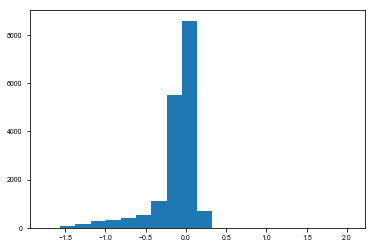

In [13]:
plt.hist(depmap.median(axis=1).values, bins=20);

In [14]:
depmap_cutoff = -0.5
depmap_symbols = depmap.index[(depmap.median(axis=1) < depmap_cutoff)].values
id_map = huri.load_id_map('hgnc_symbol', 'ensembl_gene_id')
depmap_genes = set(id_map.loc[id_map['hgnc_symbol'].isin(depmap_symbols), 'ensembl_gene_id'].values)
depmap_genes = depmap_genes.intersection(pcg)

In [16]:
print(len(omim_genes), 'OMIM disease genes')
print(len(drug_genes), 'drug targets')
print(len(cancer_genes), 'Cancer Gene Census Tier 1 genes')
print(len(gwas_genes), 'GWAS genes')
print(len(tf_genes), 'Transcription factors')
print(len(depmap_genes), 'important genes from DepMap CRISPR')

3975 OMIM disease genes
2855 drug targets
560 Cancer Gene Census Tier 1 genes
909 GWAS genes
1639 Transcription factors
1506 important genes from DepMap CRISPR


In [17]:
def genes_in_network(nw):
    return set(nw['ensembl_gene_id_a'].unique()).union(nw['ensembl_gene_id_b'].unique())

In [18]:
hi_iii = load_nw_hi_iii(id_type='ensembl_gene_id')
lit_bm = load_nw_lit_bm_17(id_type='ensembl_gene_id')

In [19]:
hi = genes_in_network(hi_iii)
litbm = genes_in_network(lit_bm)

/Users/lukelambourne/Work/ccsblib/ccsblib/huri/external_data/other_interactomes.py:91: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  bp = (pd.read_table(fpath, header=0, usecols=[col_bait, col_prey])


You may wish to use the `agg` argument to customize the choice of which of the pair's infomation to keep or how to combine the information from multiple pairs.


/Users/lukelambourne/Work/ccsblib/ccsblib/huri/external_data/other_interactomes.py:200: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  cf = (pd.read_table(fpath, usecols=['id1', 'id2'])


In [20]:
datasets = [omim_genes,
            drug_genes,
            cancer_genes,
            tf_genes,
            gwas_genes,
            depmap_genes]
ds_names = ['Disease genes',
            'Pharmacological targets',
            'Cancer genes',
            'Transcription Factors',
            'GWAS SNP genes',
            'Cell growth genes']
nws = [hi, litbm, hi.union(litbm)]
nw_names = ['HI-III-19', 'Lit-BM', 'Union']
colors = [HURI_COLOR, LIT_COLOR, HURI_COLOR]

In [21]:
nws = list(reversed(nws))
nw_names = list(reversed(nw_names))
colors = list(reversed(colors))

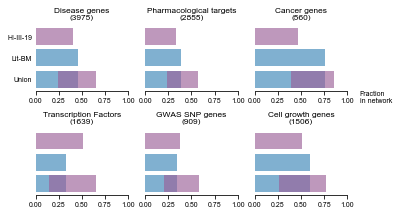

In [22]:
transparency = 0.65
fig, axes = plt.subplots(2, len(datasets) // 2)
fig.set_size_inches(5, 3.)
for ds, ax, name in zip(datasets, axes.flatten(), ds_names):
    fs = [len(nw.intersection(ds)) / len(ds) for nw in nws]
    ax.barh(range(1, len(nws)), fs[1:], color=colors[1:], alpha=transparency)
    ax.set_xlim(0., 1.)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yticks([])
    ax.set_title(name + '\n({})'.format(len(ds)))
    # add the union
    ax.barh(0, fs[1], color=LIT_COLOR, alpha=transparency) # stacked effect
    ax.barh(0, fs[2], left=fs[0] - fs[2], color=HURI_COLOR, alpha=transparency)
    
    
axes[0, 0].set_yticks(range(len(nw_names)))
axes[0, 0].yaxis.set_tick_params(length=0.)
axes[0, 0].set_yticklabels(nw_names)
fig.text(1.0, 0.52, 'Fraction\nin network')
plt.tight_layout()
for fmt in FORMATS:
    plt.savefig('../figures/gene_list_coverage' + fmt, bbox_inches='tight')

In [23]:
n_pub = load_number_publications_per_gene(protein_coding_only=True)

/Users/lukelambourne/Work/ccsblib/ccsblib/huri/external_data/gene_properties.py:32: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  gn2pm = pd.read_table(file_path)
/Users/lukelambourne/Work/ccsblib/ccsblib/huri/external_data/gene_properties.py:35: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  '../../../data/external/gene2ensembl'))


In [24]:
upper_lims = []
for ds in datasets:
    __ax, counts = cplt.samogram(hi_iii.loc[hi_iii['ensembl_gene_id_a'].isin(ds) |
                                       hi_iii['ensembl_gene_id_b'].isin(ds), :],
                             n_pub,
                             n_bins=30)
    upper_lims.append(counts.max())
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [25]:
upper_lims = [math.ceil(x / 10) * 10 for x in upper_lims]

In [26]:
def samogram_subset_double(ppis, gene_set, gene_property, n_bins,
                    ax=None,
                    id_a=None, id_b=None,
                    draw_up=True, draw_right=False, draw_scale=True,
                    reverse=False,
                    vmax=(None, None),
                    ylim=None, ylabel=None, yticks=None,
                    log=False, logy=False,
                    zticks=(None, None),
                    cmaps=('Purples', 'Blues'),
                    color='grey',
                    size_ratio=0.1,
                    pad=0.04,
                    colorbar_width='25%',
                    labels=('', '')):
    if size_ratio <= 0. or size_ratio >= 1.:
        raise ValueError('size_ratio must be between 0 and 1')
    if ax is None:
        ax = plt.gca()
    if id_a is None:
        id_a = gene_property.index.name + '_a'
    if id_b is None:
        id_b = gene_property.index.name + '_b'
    if isinstance(vmax, float) or isinstance(vmax, int):
        vmax = (vmax, vmax)
    if isinstance(cmaps, str):
        cmaps = (cmaps, cmaps)
    if isinstance(zticks[0], float) or isinstance(zticks[0], int):
        zticks = (zticks, zticks)
    cmap_a = plt.get_cmap(cmaps[0])
    cmap_b = plt.get_cmap(cmaps[1])
    cmap_a.set_under(color=(0, 0, 0, 0))  # fully transparent
    cmap_b.set_under(color=(0, 0, 0, 0))
    genes_ranked = (gene_property.sample(frac=1)  # randomize order first
                                 .sort_values()
                                 .to_frame())
    genes_ranked['rank'] = genes_ranked.reset_index().index.values
    binning = pd.qcut(genes_ranked['rank'], n_bins, labels=False)
    if reverse:
        binning = (n_bins - 1) - binning
    binned_ppis_a = (ppis[0].loc[ppis[0][id_a].isin(gene_property.index) &
                                 ppis[0][id_b].isin(gene_property.index) &
                                 (ppis[0][id_a].isin(gene_set) | 
                                  ppis[0][id_b].isin(gene_set)),
                                 [id_a, id_b]]
                            .apply(lambda x: x.map(binning), axis=0))
    binned_ppis_a_x = binned_ppis_a.min(axis=1)
    binned_ppis_a_y = binned_ppis_a.max(axis=1)
    binned_ppis_b = (ppis[1].loc[ppis[1][id_a].isin(gene_property.index) &
                                 ppis[1][id_b].isin(gene_property.index) &
                                 (ppis[1][id_a].isin(gene_set) | 
                                  ppis[1][id_b].isin(gene_set)),
                                 [id_a, id_b]]
                            .apply(lambda x: x.map(binning), axis=0))
    binned_ppis_b_x = binned_ppis_b.min(axis=1)
    binned_ppis_b_y = binned_ppis_b.max(axis=1)
    gene_set_counts = binning.groupby(binning).apply(lambda x: x.index.isin(gene_set).sum())
    xlim = (n_bins - 0.5, -0.5)  # flip direction of x axis
    if ylabel is None and gene_property.name is not None:
        ylabel = gene_property.name.replace('_', '\n').capitalize()
    panel_ratios = [1 / size_ratio - 1., 1]
    # cut out sqaure sub-area of given Axes
    # get size in inches and convert to figure fraction
    fig = plt.gcf()
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width_scale = min(bbox.width, bbox.height) / bbox.width
    height_scale = min(bbox.width, bbox.height) / bbox.height
    x0, y0, x1, y1 = ax.figbox.get_points().flatten()
    x0 = x0 + (x1 - x0) * (1 - width_scale) / 2
    x1 = x1 - (x1 - x0) * (1 - width_scale) / 2
    y0 = y0 + (y1 - y0) * (1 - height_scale) / 2
    y1 = y1 - (y1 - y0) * (1 - height_scale) / 2
    gs = gridspec.GridSpec(2, 2,
                           left=x0,
                           right=x1,
                           bottom=y0,
                           top=y1,
                           hspace=pad, wspace=pad,
                           width_ratios=panel_ratios,
                           height_ratios=panel_ratios[::-1])
    ax_main = plt.subplot(gs[1, 0])
    new_axes = [ax_main]
    if log:
        vmin = 1.
    else:
        vmin = 0.0001
    if log:
        norm = mpl.colors.LogNorm()
    else:
        norm = None
    counts_a, _, __, img_a = ax_main.hist2d(binned_ppis_a_x, binned_ppis_a_y,
                                            bins=[i - 0.5 for i in range(n_bins + 1)],
                                            cmap=cmap_a, vmin=vmin, vmax=vmax[0],
                                            norm=norm)
    counts_b, _, __, img_b = ax_main.hist2d(binned_ppis_b_y, binned_ppis_b_x,
                                            bins=[i - 0.5 for i in range(n_bins + 1)],
                                            cmap=cmap_b, vmin=vmin, vmax=vmax[1],
                                            norm=norm)

    xhigh, xlow = ax_main.get_xlim()
    ylow, yhigh = ax_main.get_ylim()
    crop_triangle_a = mpl.patches.Polygon([[xlow, yhigh],
                                           [xhigh, ylow],
                                           [xhigh, yhigh]],
                                          transform=ax_main.transData)
    img_a.set_clip_path(crop_triangle_a)
    crop_triangle_b = mpl.patches.Polygon([[xlow, yhigh],
                                           [xhigh, ylow],
                                           [xlow, ylow]],
                                          transform=ax_main.transData)
    img_b.set_clip_path(crop_triangle_b)
    ax_main.set_xticks([])
    ax_main.set_yticks([])
    ax_main.set_xlim(xlim)
    # diagonal dividing line
    ax_main.plot(ax_main.get_xlim()[::-1],
                 ax_main.get_ylim(),
                 color=ax_main.spines['top'].get_edgecolor(),
                 linewidth=ax_main.spines['top'].get_linewidth(),
                 linestyle=ax_main.spines['top'].get_linestyle())
    if draw_up:
        ax_up = plt.subplot(gs[0, 0], sharex=ax_main)
        new_axes.append(ax_up)
        ax_up.bar(x=gene_set_counts.index, height=gene_set_counts.values, width=1.0,
                  color=color)
        ax_up.set_xlim(xlim)
        ax_up.set_xticks([])
        ax_up.spines['top'].set_visible(False)
        ax_up.spines['right'].set_visible(False)
        if logy:
            ax_up.set_yscale('log')
        ax_up.set_ylabel(ylabel)
        ax_up.set_ylim(ylim)
        if yticks is not None:
            ax_up.set_yticks(yticks)
        ax_up.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%g'))
    if draw_right:
        ax_rt = plt.subplot(gs[1, 1], sharey=ax_main)
        new_axes.append(ax_rt)
        ax_rt.barh(y=gene_set_counts.index, width=gene_set_counts.values, height=1.0,
                   color=color)
        ax_rt.set_ylim((-0.5, n_bins - 0.5))
        ax_rt.set_yticks([])
        ax_rt.spines['bottom'].set_visible(False)
        ax_rt.spines['right'].set_visible(False)
        if logy:
            ax_rt.set_xscale('log')
        ax_rt.set_xlabel(ylabel)
        ax_rt.xaxis.set_label_position('top')
        ax_rt.set_xlim(ylim)
        if yticks is not None:
            ax_rt.set_xticks(yticks)
        ax_rt.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%g'))
        ax_rt.xaxis.tick_top()
    if draw_scale:
        zticks_a, zticks_b = zticks
        same_scale = vmax[0] == vmax[1]
        # I don't understand why I have to put 0.25 instead of 0.1....
        cax_a = inset_axes(ax_main,
                           width=colorbar_width, height='10%',
                           loc='lower center',
                           bbox_to_anchor=[0., -0.35, 1., 1.],
                           bbox_transform=ax_main.transAxes)
        cax_b = inset_axes(ax_main,
                           width=colorbar_width, height='10%',
                           loc='lower center',
                           bbox_to_anchor=[0., -0.25, 1., 1.],
                           bbox_transform=ax_main.transAxes)
        if zticks_a is None:
            if log:
                zticks_a = [1, 100, 1000, 10000]
            else:
                #zticks_a = [0, round(counts_a.max() / 2., 0), counts_a.max()]
                zticks_a = [0, round(vmax[0] / 2., 0), vmax[0]]
        if zticks_b is None:
            if log:
                zticks_b = [1, 100, 1000, 10000]
            else:
                zticks_b = [0, round(counts_b.max() / 2., 0), counts_b.max()]
        if same_scale:
            zticks_b = []
        cb_a = plt.colorbar(img_a,
                            cax=cax_a,
                            orientation='horizontal',
                            label='Number of interactions',
                            ticks=zticks_a,
                            format='%d')
        cb_b = plt.colorbar(img_b,
                            cax=cax_b,
                            orientation='horizontal',
                            label='',
                            ticks=zticks_b)
        cax_b.xaxis.set_ticks_position('top')
        cax_a.text(cb_a.get_clim()[1] * 1.05, 1, labels[0])
        cax_b.text(cb_b.get_clim()[1] * 1.05, 1, labels[1])
        if len(zticks_a) > 0:
            if zticks_a[0] == 0:
                cb_a.set_ticks([vmin] + zticks_a[1:])
            tick_labels = [str(int(zt)) for zt in zticks_a]
            if vmax[0] is not None:
                if vmax[0] < counts_a.max() or ((vmax[0] < counts_b.max()) and same_scale):
                    tick_labels = tick_labels[:-1] + ['≥' + tick_labels[-1]]
            cb_a.set_ticklabels(tick_labels)
        if len(zticks_b) > 0 and not same_scale:
            if zticks_b[0] == 0:
                cb_b.set_ticks([vmin] + zticks_b[1:])
            tick_labels = [str(int(zt)) for zt in zticks_b]
            if vmax[1] is not None:
                if vmax[1] < counts_b.max() and not same_scale:
                    tick_labels = tick_labels[:-1] + ['≥' + tick_labels[-1]]
            cb_b.set_ticklabels(tick_labels)
    return new_axes

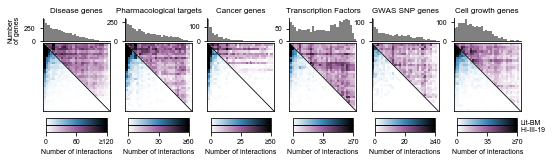

In [27]:
fig, axes = plt.subplots(1, len(datasets))
plt.subplots_adjust(wspace=-0.1, hspace=0.25)
fig.set_size_inches(9, 2.)
for ds, ax, name, vmax in zip(datasets, axes.flatten(), ds_names, upper_lims):
    new_axes = samogram_subset_double((hi_iii, lit_bm),
                                           ds,
                                           n_pub,
                                           n_bins=30,
                                           size_ratio=0.25,
                                           color='grey',
                                           draw_up=True,
                                           draw_right=False,
                                           draw_scale=True,
                                           cmaps=('HI-III-19', 'Lit-BM'),
                                           vmax=(vmax, vmax),
                                           ylabel='Number\nof genes' if name == 'Disease genes' else '',
                                           labels=('HI-III-19', 'Lit-BM') if name == 'Cell growth genes' else ('', ''),
                                           colorbar_width='90%',
                                           ax=ax)
    new_axes[1].set_title(name, fontsize=8)
for fmt in FORMATS:
    plt.savefig('../figures/samogram_grid_genes_of_interest' + fmt,
                bbox_inches='tight')